<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/titanic/titanic/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 40.6 MB/s 
     |████████████████████████████████| 189 kB 48.6 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 331 kB/s 
Mounted at /content/gdrive


In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
from fastbook import *
from kaggle import api
from fastai.tabular.all import *

In [5]:
!rm -r ~/titanic
!mkdir ~/titanic

rm: cannot remove '/root/titanic': No such file or directory


In [9]:
api.competition_download_cli('titanic', path='titanic', force=True)

100%|██████████| 34.1k/34.1k [00:00<00:00, 16.4MB/s]

In [14]:
import zipfile
z= zipfile.ZipFile('titanic/titanic.zip')
z.extractall()

In [50]:
train = pd.read_csv('train.csv', low_memory = False)
test = pd.read_csv('test.csv', low_memory = False)

In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
dep_var = 'Survived'

In [36]:
cont, cat = cont_cat_split(train, max_card=700, dep_var=dep_var)
cont, cat

(['PassengerId', 'Age', 'Fare'],
 ['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'])

In [33]:
train[cat].nunique()

Pclass        3
Name        891
Sex           2
SibSp         7
Parch         7
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [40]:
procs = [Categorify, FillMissing, Normalize]
tabular_data = TabularPandas(train,
                             procs,
                             cat,
                             cont,
                             splits=RandomSplitter(valid_pct=0.2)(range_of(train)),
                             y_names=dep_var,
                             y_block = CategoryBlock )

In [41]:
dls = tabular_data.dataloaders(64)
dls.show_batch()

,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,Age_na,PassengerId,Age,Fare,Survived
0,3,"McGowan, Miss. Anna ""Annie""",female,0,0,330923,#na#,Q,False,22.999998,15.000000,8.029199,1
1,3,"Kelly, Mr. James",male,0,0,363592,#na#,S,False,696.999993,44.000000,8.050001,0
2,1,"Van der hoef, Mr. Wyckoff",male,0,0,111240,B19,S,False,171.000013,60.999999,33.500000,0
3,3,"Sage, Mr. Douglas Bullen",male,8,2,CA. 2343,#na#,S,True,847.000013,28.000000,69.550003,0
4,3,"Danoff, Mr. Yoto",male,0,0,349219,#na#,S,False,321.999997,27.000000,7.895800,0
5,1,"Daly, Mr. Peter Denis",male,0,0,113055,E17,S,False,858.000014,51.000001,26.549999,1
6,2,"Garside, Miss. Ethel",female,0,0,243880,#na#,S,False,576.999992,34.000000,13.000001,1
7,3,"Gustafsson, Mr. Alfred Ossian",male,0,0,7534,#na#,S,False,877.000001,20.000000,9.845801,0
8,1,"Crosby, Capt. Edward Gifford",male,1,1,WE/P 5735,B22,S,False,745.999985,70.000000,71.000001,0
9,3,"Bourke, Mrs. John (Catherine)",female,1,1,364849,#na#,Q,False,657.999992,32.000000,15.500000,0


SuggestedLRs(valley=0.0030199517495930195)

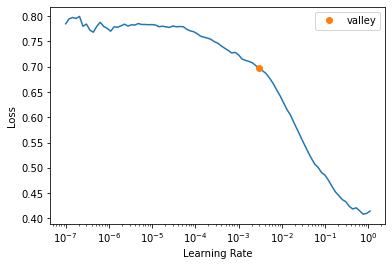

In [43]:
learn = tabular_learner(dls,
                        metrics=[accuracy],
                        loss_func = CrossEntropyLossFlat())
learn.lr_find()

In [44]:
learn.fit_one_cycle(2, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.646276,0.528687,0.780899,00:00
1,0.372614,0.459273,0.814607,00:00


SuggestedLRs(valley=0.00363078061491251)

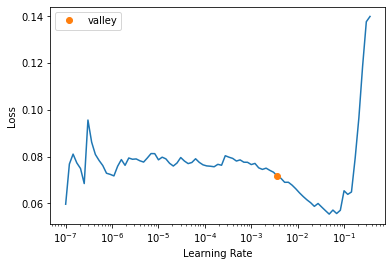

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(5, 3e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.086497,0.435001,0.814607,00:00
1,0.060952,0.433324,0.808989,00:00
2,0.044671,0.456175,0.808989,00:00
3,0.033909,0.473014,0.814607,00:00
4,0.025726,0.477795,0.814607,00:00


In [57]:
test['Fare'] = test['Fare'].fillna(0)

In [59]:
test_dl = learn.dls.test_dl(test)
predictions = learn.get_preds(dl=test_dl)

In [74]:
preds_value = np.argmax(predictions[0], axis=1)

In [76]:
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': preds_value})
result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [81]:
result.to_csv('result.csv', index=False)

In [82]:
api.competition_submit_cli('result.csv', 'result', 'titanic')

100%|██████████| 2.77k/2.77k [00:09<00:00, 312B/s]


Successfully submitted to Titanic - Machine Learning from Disaster